In [1]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import models, datasets
import torchvision.transforms as transforms
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, random_split

# Hyperparameters
N_EPOCHS = 10
LEARNING_RATE = 0.001
TEST_SIZE=0.40

# Transformations for our dataset
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.ToTensor(),          # Convert PIL image to PyTorch tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to range [-1, 1] for better training stability
])

# Load the dataset
root_dir = 'data_zadanie2/'  # Modify this to the path where your image folders (cat, chicken, etc.) are located
full_dataset = datasets.ImageFolder(root=root_dir, transform=transform)

# Splitting the dataset
train_size = int((1 - TEST_SIZE) * len(full_dataset))
test_size = len(full_dataset) - train_size

train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [2]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()

        # Define each fully connected block using nn.Sequential
        self.fc_block1 = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU()
        )

        self.fc_block2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU()
        )

        self.fc_block3 = nn.Sequential(
            nn.Linear(256, 128),
            nn.Sigmoid()
        )

        # Output layer with softmax
        self.fc_block4 = nn.Sequential(
            nn.Linear(128, 10),
            nn.Softmax()
        )

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the input tensor
        x = self.fc_block1(x)
        x = self.fc_block2(x)
        x = self.fc_block3(x)
        x = self.fc_block4(x)
        return x


In [3]:
class TestNet(nn.Module):
    def __init__(self):
        super(TestNet, self).__init__()

        self.conv1 = nn.Sequential(
        # in_channels = 1, grayscale image
        # out_channels = 12, num of kernels
        # kernel_size = 3 size of kernel 3x3
        # padding adding zeros around output img 
        # stride, step of kernel
        nn.Conv2d(in_channels=1, out_channels=12, kernel_size=3, padding=1, stride=1), # (N, 1, 28, 28)
        # output feature map of layer =  [(Input Height - Kernel Height + 2 * Padding) / Stride] + 1
        # out_features = [(28 - 3 + 2 * 1)/1] + 1 = 28 [x=28,y=28]
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)        # out_features = 28/2 = 14 [x=14,y=14]
        )

        self.conv2 = nn.Sequential(
        nn.Conv2d(in_channels=12,out_channels=24,kernel_size=3,padding=1,stride=1),
        # out_features = [(14 -3 + 2 *1) / 1] + 1 = 14 [x=14,y=14]
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
        # out_features = 14 /2 = 7  [x=7,y=7]
        )
        self.fc_layers = nn.Sequential(
        # layer that flatten 2D feature maps into 1D
        nn.Flatten(),
        # Fully connected layers
        # in_features  = [num of feature maps] * [feature map width] * [feature map height]
        # out_features -> num of neurons in layer
        nn.Linear(in_features=24*7*7,out_features=64),
        nn.ReLU(),
        nn.Dropout(p=0.2),
        nn.Linear(in_features=64,out_features=10), # 10 classes 
        nn.Softmax()
        )

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.fc_layers(out)
        return out

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # First convolutional layer: 1 input channel, 32 output channels
        # Kernel size: 3x3
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling with 2x2 window
        
        # Second convolutional layer: 32 input channels, 64 output channels
        # Kernel size: 3x3
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        
        # Fully connected layer: 64*7*7 input neurons (from the last convolutional layer)
        # 128 output neurons
        self.fc1 = nn.Linear(64*7*7, 128)
        
        # Output layer: 128 input neurons, 10 output neurons (one for each class A-J)
        self.fc2 = nn.Linear(128, 10)
        
        # Activation function: ReLU
        self.relu = nn.Softmax()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64*7*7)  # Flatten the tensor
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [5]:
import torch.nn as nn
import torch.nn.functional as F

class BasicCNN(nn.Module):
    def __init__(self):
        # Call the parent __init__ function
        super(BasicCNN, self).__init__()

        # First convolutional layer:
        # 1 input channel (because the image is grayscale),
        # 32 output channels, 3x3 square convolution kernel
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        
        # Second convolutional layer:
        # 32 input channels (from the previous layer),
        # 64 output channels, 3x3 square convolution kernel
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        
        # Dropout layer to reduce overfitting; drops 25% of nodes
        self.dropout1 = nn.Dropout(0.25)
        
        # Another dropout layer, but drops 50% of nodes
        self.dropout2 = nn.Dropout(0.5)
        
        # First fully connected (dense) layer: 
        # 9216 input features (from the previous layer after flattening),
        # 128 output features
        self.fc1 = nn.Linear(9216, 128)
        
        # Second fully connected layer that reduces to 10 outputs (for the 10 classes A-J)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Pass input through the first convolutional layer, then apply ReLU activation function
        x = self.conv1(x)
        x = F.relu(x)

        # Pass through the second convolutional layer, then apply ReLU activation
        x = self.conv2(x)
        x = F.relu(x)

        # Apply max pooling with 2x2 window
        x = F.max_pool2d(x, 2)

        # Apply first dropout layer
        x = self.dropout1(x)

        # Flatten the tensor
        x = torch.flatten(x, 1)

        # Pass through the first fully connected layer, then apply ReLU activation
        x = self.fc1(x)
        x = F.relu(x)

        # Apply second dropout layer
        x = self.dropout2(x)

        # Pass through the second fully connected layer
        x = self.fc2(x)

        # Apply softmax to get probabilities; return result
        return F.log_softmax(x, dim=1)


In [6]:
class AnimalCNN(nn.Module):
    def __init__(self):
        super(AnimalCNN, self).__init__()

        # Define each convolutional block using nn.Sequential
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1),  # Input channels changed to 3
            nn.ReLU()
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, 1),
            nn.ReLU()
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.5)
        )
        
        # The feature map dimensions change based on the convolutions and poolings
        self.fc1 = nn.Sequential(
            nn.Linear(256 * 29 * 29, 128),  # Adjusted for 128x128 input image
            nn.ReLU()
        )

        self.fc2 = nn.Sequential(
            nn.Linear(128, 8),  # 8 classes for the 8 animals
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x


In [7]:
import torch.nn as nn
import torch

class DeeperAnimalCNN(nn.Module):
    def __init__(self):
        super(DeeperAnimalCNN, self).__init__()

        # Convolutional blocks
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),  # Retain the same spatial size with padding
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.5)
        )
        
        self.conv5 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.5)
        )

        # Fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(512 * 4 * 4, 1024),  # Adjusted for pooling layers
            nn.ReLU(),
            nn.Dropout(0.5)
        )

        self.fc2 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

        self.fc3 = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

        self.fc4 = nn.Linear(128, 8)  # 8 classes for the 8 animals

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        return x


In [ ]:
import torch.nn as nn
import torch

class DeepSerialParallelAnimalCNN(nn.Module):
    def __init__(self):
        super(DeepSerialParallelAnimalCNN, self).__init__()

        # Common layers
        self.common = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # Branch 1
        self.branch1 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # Branch 2
        self.branch2 = nn.Sequential(
            nn.Conv2d(64, 128, 5, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 5, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # Combined Branches
        self.combined = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(512, 1024, 3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # Fully Connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(1024 * 4 * 4, 2048),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        
        self.fc2 = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

        self.fc3 = nn.Linear(512, 8)  # 8 classes for the 8 animals

    def forward(self, x):
        x = self.common(x)

        x1 = self.branch1(x)
        x2 = self.branch2(x)

        # Concatenate along the channel dimension
        x = torch.cat((x1, x2), dim=1)

        x = self.combined(x)
        x = torch.flatten(x, 1)
        
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)

        return x


In [8]:
class ShallowCNN(nn.Module):
    def __init__(self):
        super(ShallowCNN, self).__init__()
        output_channels=32
        
        self.conv1 = nn.Conv2d(1, output_channels, 3, 1)
        
        # Only one dropout layer
        self.dropout = nn.Dropout(0.5)
        
        # Adjusted input features for the single fully connected layer
        self.fc1 = nn.Linear(output_channels * 26 * 26, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)


In [9]:
# initialize the models
cnn_model = DeeperAnimalCNN()


In [10]:
# define the loss functions and optimizers
criterion = nn.CrossEntropyLoss()
cnn_optimizer = torch.optim.Adam(cnn_model.parameters(), lr=LEARNING_RATE)

In [11]:
def evaluate_model(model, dataloader):
    """
    Evaluate the given model using the specified dataloader.

    Args:
    - model: Trained PyTorch model
    - dataloader: DataLoader for the evaluation data

    Returns:
    - Accuracy of the model on the evaluation data
    """
    correct = 0
    total = 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()  # Set model to evaluation mode

    with torch.no_grad():  # No need to track gradients during evaluation
        for inputs, labels in tqdm(test_loader, desc="Evaluation", leave=False):
            inputs, labels = inputs.to(device).float(), labels.to(device)  # Move inputs and labels to the device and ensure float32 type
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

In [12]:
# Training
def train_model(model, optimizer, criterion, dataloader, epochs=30):
    """
    Train a given model using the specified optimizer and criterion.

    Args:
    - model: PyTorch model to be trained
    - optimizer: Optimizer for updating model parameters
    - criterion: Loss function
    - dataloader: DataLoader for the training data
    - epochs: Number of epochs (default=10)

    Returns:
    - list of losses per epoch
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()  # Set the model to training mode
    loss_list = []  # To store the loss per epoch
    accuracy_list= []

    # Loop over epochs
    for epoch in trange(epochs, desc="Epochs"):
        # ... [rest of the code remains unchanged]
        epoch_loss = 0  # Initialize epoch loss

        for inputs, labels in tqdm(train_loader, desc="Batches", leave=False):
            inputs, labels = inputs.to(device).float(), labels.to(device)
            optimizer.zero_grad()  # Clear gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

            epoch_loss += loss.item()
        accuracy=evaluate_model(model, DataLoader(test_dataset, batch_size=64))
        accuracy_list.append(accuracy)
        avg_loss = epoch_loss / len(dataloader)
        loss_list.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")
    model.eval()
    return loss_list,accuracy_list

In [13]:
if torch.cuda.is_available():
    print("cuda")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming cnn_model is defined and moved to the correct device as well:
cnn_model.to(device)

# Training the CNN model
cnn_losses,cnn_accuracy_list = train_model(cnn_model, cnn_optimizer, criterion, DataLoader(train_dataset, batch_size=64, shuffle=True), epochs=N_EPOCHS)

# Evaluating the CNN model
cnn_accuracy = evaluate_model(cnn_model, DataLoader(test_dataset, batch_size=64))
print(f"CNN Model Accuracy: {cnn_accuracy:.2f}%")


cuda


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/181 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/121 [00:00<?, ?it/s]

Epoch 1/10 - Loss: 1.9709


Batches:   0%|          | 0/181 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/121 [00:00<?, ?it/s]

Epoch 2/10 - Loss: 1.6406


Batches:   0%|          | 0/181 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/121 [00:00<?, ?it/s]

Epoch 3/10 - Loss: 1.4548


Batches:   0%|          | 0/181 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/121 [00:00<?, ?it/s]

Epoch 4/10 - Loss: 1.3125


Batches:   0%|          | 0/181 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/121 [00:00<?, ?it/s]

Epoch 5/10 - Loss: 1.1490


Batches:   0%|          | 0/181 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/121 [00:00<?, ?it/s]

Epoch 6/10 - Loss: 1.0042


Batches:   0%|          | 0/181 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/121 [00:00<?, ?it/s]

Epoch 7/10 - Loss: 0.8570


Batches:   0%|          | 0/181 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/121 [00:00<?, ?it/s]

Epoch 8/10 - Loss: 0.7213


Batches:   0%|          | 0/181 [00:00<?, ?it/s]

In [ ]:
import matplotlib.pyplot as plt

def plot_accuracy(accuracy_list, model_name):
    """
    Plots the accuracy for each epoch based on the provided accuracy list.

    Args:
    - accuracy_list: List of accuracy values (one for each epoch).
    - model_name: Name of the model, for labeling purposes.

    Returns:
    - None (Displays the plot)
    """
    
    plt.figure(figsize=(12, 6))
    plt.plot(accuracy_list, '-o', label=f'{model_name} Accuracy')
    plt.title(f'Accuracy Evolution for {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

# Example usage:
# plot_accuracy(mlp_accuracy_list, 'MLP')


In [ ]:
import matplotlib.pyplot as plt

def plot_losses(mlp_losses, cnn_losses):
    # Initialize a new figure for plotting with a specified size.
    plt.figure(figsize=(12, 6))
    
    # Plot the MLP model's losses in blue.
    plt.plot(mlp_losses, label="MLP Model", color='blue')
    
    # Plot the CNN model's losses in red.
    plt.plot(cnn_losses, label="CNN Model", color='red')
    
    # Title of the plot.
    plt.title("Training Loss over Epochs")
    
    # Labels for the x and y axes.
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    
    # Display the legend to differentiate between MLP and CNN.
    plt.legend()
    
    # Display a grid for better readability.
    plt.grid(True)
    
    # Show the plot.
    plt.show()



In [ ]:
import matplotlib.pyplot as plt

def plot_accuracy(accuracy_list, model_name):
    """
    Plots the accuracy for each epoch based on the provided accuracy list.

    Args:
    - accuracy_list: List of accuracy values (one for each epoch).
    - model_name: Name of the model, for labeling purposes.

    Returns:
    - None (Displays the plot)
    """
    
    plt.figure(figsize=(12, 6))
    plt.plot(accuracy_list, '-o', label=f'{model_name} Accuracy')
    plt.title(f'Accuracy Evolution for {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

# Example usage:
# plot_accuracy(mlp_accuracy_list, 'MLP')


In [ ]:
def plot_filters(layer, layer_idx=0):
    # Extract filter weights from the layer and convert to numpy for visualization.
    filters = layer[layer_idx].weight.data.cpu().numpy()
    
    # Initialize a figure for displaying multiple images.
    fig = plt.figure(figsize=(10, 5))
    
    # Loop through each filter in the layer.
    for i in range(filters.shape[0]):
        ax = fig.add_subplot(2, filters.shape[0]//2, i+1) # arranging subplots in 2 rows.
        
        # Display the filter as an image.
        ax.imshow(filters[i][0], cmap='gray')
        
        # Don't show axis for clarity.
        ax.axis('off')
    
    # Show all the filter images.
    plt.show()



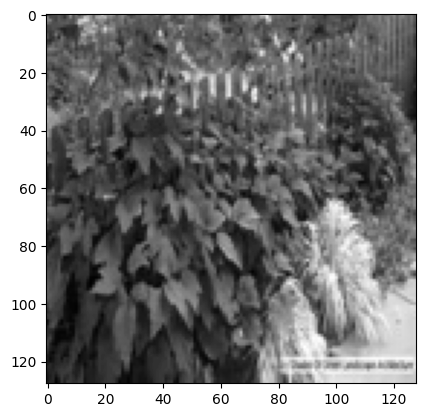

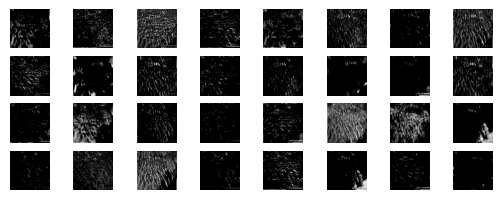

In [ ]:
def visualize_feature_maps(model, input_image):
    # Making sure model is in eval mode
    model.eval()
    
    # Running the image through the first conv layer
    feature_maps1 = model.conv1(input_image.unsqueeze(0).float().to(device))
    # If you want to visualize after the second conv layer
    # feature_maps2 = model.conv2(F.relu(feature_maps1))
    
    n_feature_maps = feature_maps1.shape[1]
    
    # Plotting each feature map
    for i in range(n_feature_maps):
        plt.subplot(8, 8, i+1)  # Assuming a max of 64 feature maps for display
        plt.imshow(feature_maps1[0][i].cpu().detach().numpy(), cmap='gray')
        plt.axis('off')
    plt.show()

# Select a random image from the dataset
image, _ = test_dataset[5]
plt.imshow(image[0], cmap='gray')  # Displaying the selected image
plt.show()

# Displaying feature maps for the selected image
visualize_feature_maps(cnn_model, image)

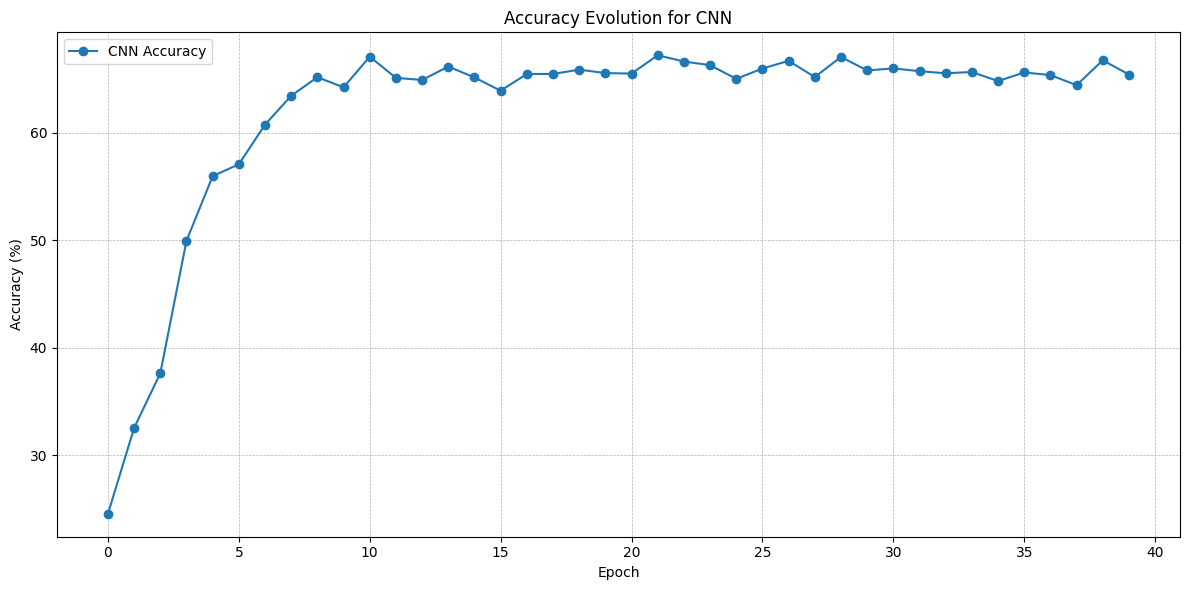

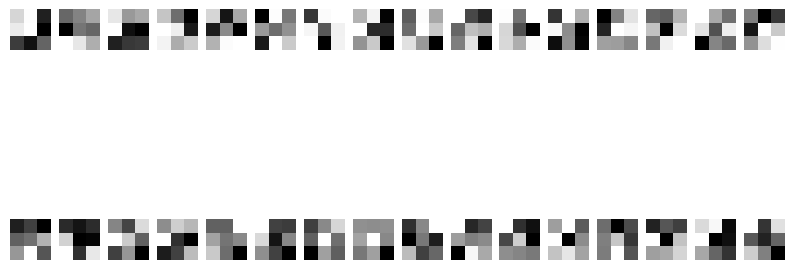

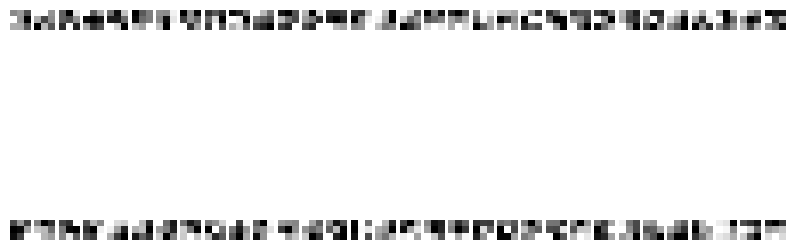

In [ ]:
plot_accuracy(cnn_accuracy_list, "CNN")
plot_filters(cnn_model.conv1,0)
plot_filters(cnn_model.conv2,0)

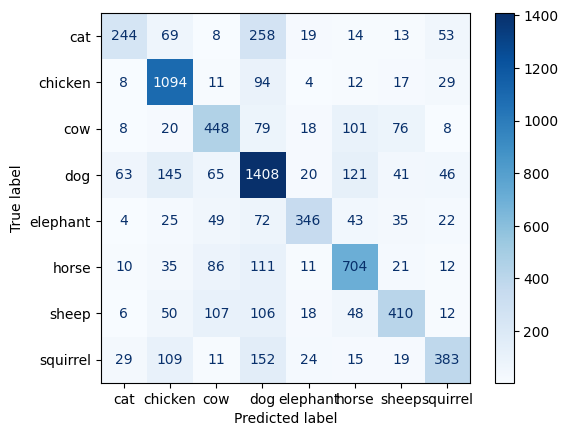

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def get_all_preds_and_labels(model, dataloader):
    # Empty tensors to store all predictions and true labels.
    all_preds = torch.tensor([]).to(device)
    all_labels = torch.tensor([]).to(device)
    
    # Loop through the data in the dataloader.
    for inputs, labels in dataloader:
        # Convert inputs to float32
        inputs = inputs.float()
        # Move the data to the device (GPU/CPU).
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass to get predictions.
        outputs = model(inputs)
        
        # Get the index (class label) with the maximum score as the prediction.
        _, preds = torch.max(outputs, 1)
        
        # Append the batch's predictions and labels to the accumulating tensors.
        all_preds = torch.cat((all_preds, preds), dim=0)
        all_labels = torch.cat((all_labels, labels), dim=0)
    
    # Return all predictions and true labels.
    return all_preds, all_labels

import numpy as np
from sklearn import metrics

def plot_confusion_matrix(all_preds, all_labels):
    # Compute the confusion matrix using sklearn's function.
    cm = metrics.confusion_matrix(all_labels.cpu(), all_preds.cpu())
    
    # Define the labels you're using (in this case, it's A-J).
    labels = ["cat","chicken","cow","dog","elephant","horse","sheep","squirrel"]
    
    # Create the ConfusionMatrixDisplay object.
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    
    # Plot the confusion matrix.
    cm_display.plot(cmap='Blues')
    plt.show()

# After training your CNN model
cnn_model = cnn_model.float()
all_preds, all_labels = get_all_preds_and_labels(cnn_model, DataLoader(test_dataset, batch_size=64))
plot_confusion_matrix(all_preds, all_labels)
